# **计算基因组中各基因的拷贝数**
## **1.	Prodigal+OrthoFinder方法**
Prodigal（PROkaryotic DYnamic programming Gene-finding ALgorithm）是一种用于细菌和古细菌基因组的蛋白质编码基因预测软件工具，由美国橡树岭国家实验室和田纳西大学的Doug Hyatt团队于2010年正式发表，2012年增发MetaProdigal专用于宏基因组数据，是目前应用最广泛的基因预测软件之一。这里我们使用Prodigal预测每个基因组的编码序列，输入文件为各菌种基因组序列（.fna文件），输出结果为预测基因的蛋白质序列（.faa文件）。

**代码示例：**

In [ ]:
cd ./CompleteGenome_noplasmid  # 存储.fna文件的目录
mkdir prodigal_res  # prodigal计算结果目录
for fna_file in *.fna; do
    res_file_name="${fna_file%.fna}"
    prodigal -i "$fna_file" -a "./prodigal_res/$res_file_name.faa"
done

随后我们使用OrthoFinder对所有菌株的基因进行聚类。这是一款广泛应用于比较基因组学和系统发育学研究的生物信息学工具，其主要功能是通过分析蛋白质序列推断直系同源基因、旁系同源基因及基因家族的演化关系，同时整合基因树和物种树信息以提供全面的进化分析。输出文件Orthogroups.GeneCount.tsv记录了每个基因家族在各菌株中的拷贝数，Orthogroups.txt记录了每个基因家族所包含的基因。

**代码示例：**


In [ ]:
orthofinder -f ./prodigal_res -t 8 -a 8

**部分结果展示：**

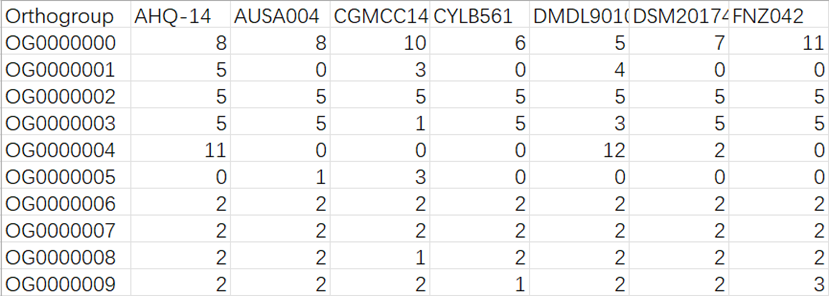

图1-1 Orthogroups.GeneCount.tsv 中部分结果

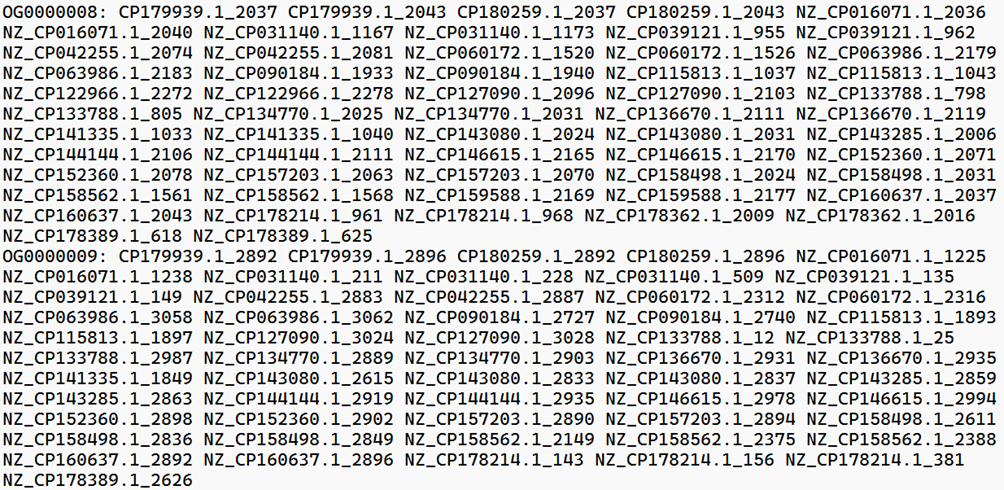

图1-2 Orthogroups.txt 中部分结果

## **2.	Prokka+Python方法**
Prokka是一种适用于原核生物的基因组自动注释工具，由墨尔本大学生物信息学家Torsten Seemann开发。它协调了一套现有的软件工具，可对原核基因组和宏基因组进行快速高效的功能注释。这里我们使用Prokka对每个菌种的基因组（.fna文件）进行基因预测和注释，生成包含所有编码基因的核苷酸序列文件（.ffn文件），以及注释基因的列表（.tsv文件）。

**代码示例：**


In [ ]:
cd ./CompleteGenome_noplasmid  # 存储.fna文件的目录
mkdir prokka_res  # prokka计算结果目录
for fna_file in *.fna; do
    res_file_name="${fna_file%.fna}"
    prokka --outdir "./prokka_res/$res_file_name" --prefix "$res_file_name" "$fna_file"
done


随后编写shell脚本将结果中的所有.ffn文件和.tsv文件汇总到一个文件夹中。

**代码示例：**

In [ ]:
cd ./CompleteGenome_noplasmid  # 存储.fna文件的目录
cd prokka_res
# ffn
target_dir="ffn_file"
mkdir -p "$target_dir"
find . -type f -name "*.ffn" -print0 | while IFS= read -r -d '' file; do
    filename=$(basename "$file")
    cp -v --backup=numbered "$file" "\$target_dir/\$filename"
done
# tsv
target_dir="tsv_file"
mkdir -p "$target_dir"
find . -type f -name "*.tsv" -print0 | while IFS= read -r -d '' file; do
    filename=$(basename "$file")
    cp -v --backup=numbered "$file" "\$target_dir/\$filename"
done


最后使用Python脚本处理.ffn文件，计算每个基因序列的拷贝数，具体原理为通过哈希值唯一标识每个序列，统计其出现次数。之后根据.tsv文件将Prokka生成的基因标识符替换成通用geneID，并将基因的不同位置多拷贝（xxx_1、xxx_2等）进行合并，得到真实的拷贝数。

**代码示例：**

In [ ]:
# 01_getCopyNumber
import hashlib
import os
from Bio import SeqIO
from collections import defaultdict
def parse_prokka_tsv(tsv_path):
    locus_to_gene = {}
    with open(tsv_path, 'r', encoding='utf-8') as f:
        headers = f.readline().strip().split('\t')
        locus_idx = headers.index('locus_tag')
        gene_idx = headers.index('gene')
        for line in f:
            cols = line.strip().split('\t')
            if len(cols) < max(locus_idx, gene_idx) + 1:
                continue  # 跳过不完整行
            locus_tag = cols[locus_idx].strip()
            gene = cols[gene_idx].strip()
            if gene:  # 只保留有geneID的条目
                locus_to_gene[locus_tag] = gene
    return locus_to_gene
def process_genome(ffn_path, tsv_path, 
output_csv="combined_gene_copies.csv"):
    genome_name = os.path.splitext(os.path.basename(ffn_path))[0]
    gene_data = []
    # 统计单个基因组内的拷贝数
    hash_counts = defaultdict(int)
    seq_hash_map = {}  # 记录基因ID与哈希的映射
    for record in SeqIO.parse(ffn_path, "fasta"):
        gene_id = record.id
        seq = str(record.seq).upper().replace(' ', '')
        seq_hash = hashlib.md5(seq.encode()).hexdigest()
        seq_hash_map[gene_id] = seq_hash
        hash_counts[seq_hash] += 1
    # 获取Prokka基因标识符到geneID的映射
    prokka_to_geneid = parse_prokka_tsv(tsv_path)
    # 按基因ID整理数据并添加菌种信息
    for prokka_id, seq_hash in seq_hash_map.items():
        copy_number = hash_counts[seq_hash]
        gene_id = prokka_to_geneid.get(prokka_id)
        if not gene_id:
            continue
        gene_data.append({
            "Genome": genome_name,
            "GeneID": gene_id,
            "CopyNumber": copy_number
        })
    # 追加写入总表
    with open(output_csv, 'a') as f:
        if os.stat(output_csv).st_size == 0:  # 文件为空时写入表头
            f.write("Genome,GeneID,CopyNumber\n")
        for entry in gene_data:
            line =
            f"{entry['Genome']},{entry['GeneID']},{entry['CopyNumber']}\n"
            f.write(line)
if __name__ == '__main__':
    ffn_files = "./ffn_file"
    tsv_files = "./tsv_file"
    for ffn_file in os.listdir(ffn_files):
        if ffn_file.endswith(".ffn"):
            file_name_with_extension = os.path.basename(ffn_file)
            file_name, extension =
            os.path.splitext(file_name_with_extension)
            ffn_path = os.path.join(ffn_files, ffn_file)
            process_genome(ffn_path, f"{tsv_files}/{file_name}.tsv")

# 02_long2wide
import pandas as pd
input_csv = "combined_gene_copies.csv"
output_csv = "combined_gene_copies_wide.csv"
df = pd.read_csv(input_csv)
# 长变宽
pivot_df = df.pivot_table(
    index='Genome',
    columns='GeneID',
    values='CopyNumber',
    fill_value=0,
).reset_index()  # 将索引转换为普通列
pivot_df.to_csv(output_csv, index=False)

# 03_mergeSameGene
import pandas as pd
input_csv = "combined_gene_copies_wide.csv"
output_csv = "combined_gene_copies_wide_merge.csv"
df = pd.read_csv(input_csv)
# 合并相同基因
cols_to_remove = []  # 存储需要删除的列
for col in df.columns:  # 遍历所有列
    if '_' in col:
        parts = col.split('_')
        # 确保是a_b格式且只包含一个下划线
        if len(parts) == 2:
            prefix = parts[0]
            # 如果前缀列不存在则创建
            if prefix not in df.columns:
                df[prefix] = 0
            # 数值相加（处理NaN值）
            df[prefix] = df[prefix].fillna(0) + df[col].fillna(0)
            cols_to_remove.append(col)
df.drop(columns=cols_to_remove, inplace=True)  # 删除原始带下划线的列
df.to_csv(output_csv, index=False)


**部分结果展示：**

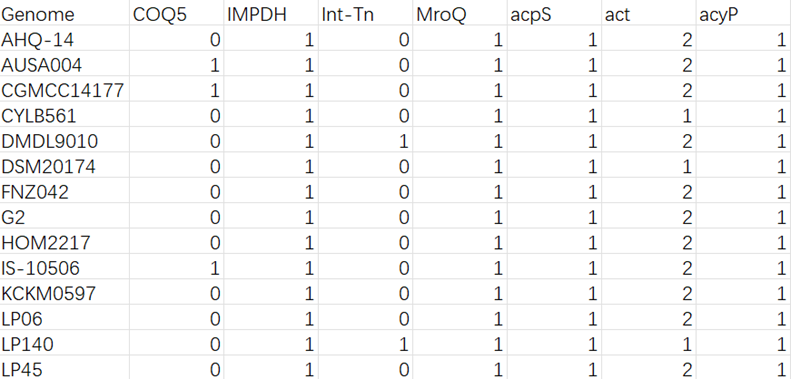

图2 combined_gene_copies_wide_merge.csv 中部分结果

## **3.	基于读对的近似计算方法**
目前我们已从 NCBI 等数据库下载获得实验菌株（包括模式菌株）的基因组序列与基因注释文件。可利用 BWA、Samtools、Bedtools 等生物信息学工具，通过测序深度与序列比对计算各基因的拷贝数。该方法基于假设：测序数据分布均匀，即测序深度与拷贝数成正比。由此可推导出，单拷贝基因的测序覆盖度应与基因组的平均覆盖度接近，多拷贝基因的测序覆盖度应是单拷贝基因的倍数。故基因拷贝数可由以下公式近似给出：

$$
\text{基因拷贝数} = \frac{\text{单个基因覆盖度}}{\text{基因组平均覆盖度}}
$$

该方法主要思路为：比对菌株全基因组序列至参考基因组（即模式菌株基因组），计算各个基因覆盖度与基因组的平均覆盖度，得到基因拷贝数，归一化拷贝数信息输出结果。

**代码示例：**

In [ ]:
#!/bin/bash
## 配置环境与路径
BIN=/home/your_hostname/miniconda3/envs/your_environment/bin
mkdir -p Genome_copynumber
cd Genome_copynumber
PROJECT_HOME=`$PWD`
mkdir -p Genmeo_data
mkdir -p Reference_genome
DATA=`$PWD/Genome_data`
RESULT=`$PWD/results`
mkdir -p $RESULT

## 设置参考基因组
REFERENCE_GENOME=`$PROJECT_HOME/Reference_genome/your_Reference_genome.fna`
REFERENCE_GFF=`$PROJECT_HOME/Reference_genome/your_Reference_genome.gff`

## 进行序列比对
mkdir -p `$RESULT/aligned`
for sample in `$DATA/*.fna`
do
    RESULT/aligned/${sample_name}_aligned.bam
    bwa mem `$REFERENCE_GENOME $SAMPLE_READS` > `$ALIGNMENT_OUTPUT.sam`
    samtools view -Sb `$ALIGNMENT_OUTPUT.sam` > `$ALIGNMENT_OUTPUT.bam`
    samtools sort $ALIGNMENT_OUTPUT.bam -o $ALIGNMENT_OUTPUT.sorted.bam
    samtools index $ALIGNMENT_OUTPUT.sorted.bam
    bedtools coverage -a $REFERENCE_GFF -b $ALIGNMENT_OUTPUT.sorted.bam > $RESULT/copy_number/$ {sample_name}_coverage.txt
done

## 计算各样本中每个基因的拷贝数
for coverage_file in $RESULT/copy_number/*_coverage.txt
do
    sample_name=$(basename "$coverage_file" _coverage.txt)
    avg_coverage=$(awk '$3 == "gene" {sum+=$11; count++} END {if (count > 0) print sum/count; else print "ERROR: No genes found"}' "$coverage_file")
    awk -v sample="$sample_name" -v avg_cov="$avg_coverage" '
    $3 == "gene" {
       split($9, arr, ";");
       gene_name = "unknown";
       for (i in arr) {
            if (arr[i] ~ /^Name=/) {
                gene_name = substr(arr[i], 6);
            }
       }
        coverage = $(NF-2);
        copy_number = coverage / avg_cov;
        print sample, gene_name, copy_number;
    }' "$coverage_file" > "$RESULT/copy_number/${sample_name}_copy_number.tsv"

    echo "Processed $sample_name"
done

## 合并拷贝数结果至同一文件
INPUT_DIR="results/copy_number"
OUTPUT_FILE="results/merged_copy_number.tsv"
awk '1 {print $2}' $INPUT_DIR/*.tsv | sort | uniq > gene_names.txt
echo -e "Sample\t$(paste -sd '\t' gene_names.txt)" > $OUTPUT_FILE

for file in $INPUT_DIR/*.tsv
do
    sample_name=$(basename "$file" copy_number.tsv)
    declare -A copy_number_map
    awk '{copy[$2] = $4} END {for (gene in copy) print gene, copy[gene]}' "$file" > temp_copy.txt
    printf "%s" "$sample_name" > temp_row.txt
    while read -r gene; do
        value=$(grep -w "$gene" temp_copy.txt | awk '{print $2}')
        printf "\t%s" "${value:-0}" >> temp_row.txt
    done < gene_names.txt
    echo "" >> temp_row.txt

    cat temp_row.txt >> $OUTPUT_FILE
done
rm gene_names.txt temp_copy.txt temp_row.txt

echo "✅ mission complete！result file：$OUTPUT_FILE"


**部分结果展示：**

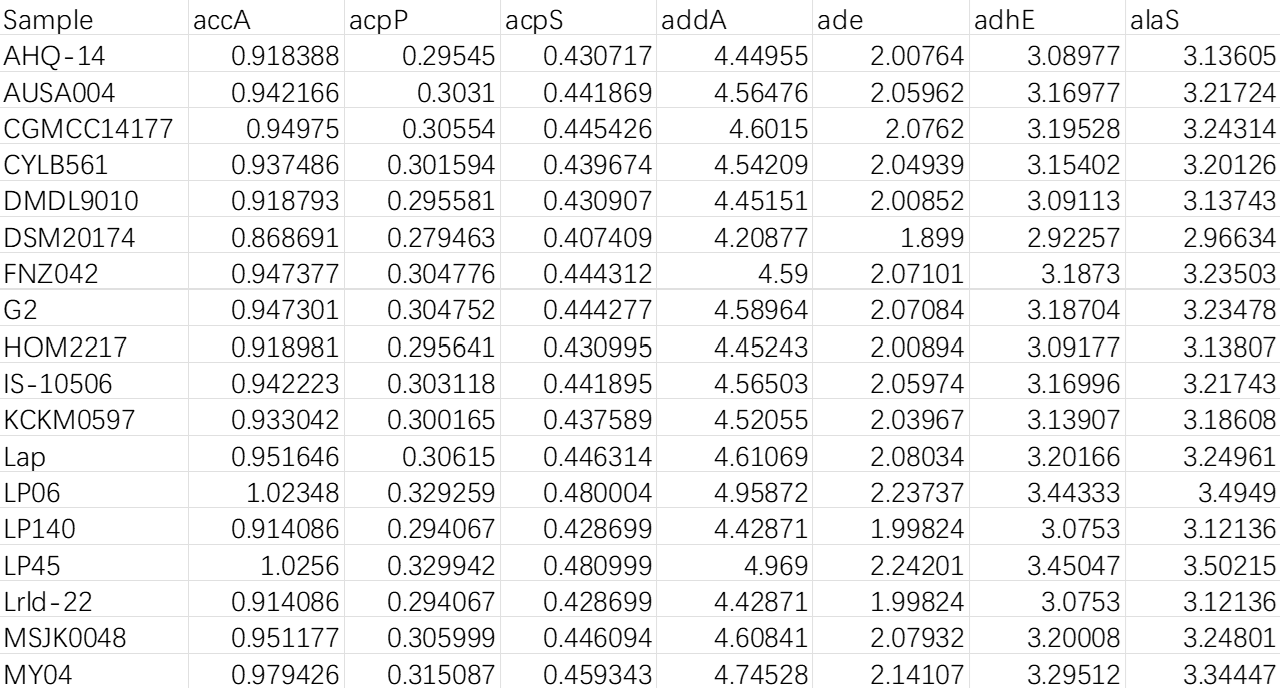

图3 拷贝数结果汇总部分结果